# Ibis-framework: aprimorando el workflow de análisis de datos

## Descripción del taller:

Este taller presentará la biblioteca Ibis, sus benefícios, situaciones dónde los usuarios podrán usarlo y las operaciones más comunes disponibles. Para ello se utilizará el backend OmniSciDB/MapD.

**Nivel:** Iniciante

## Introducción

Ibis-framework (tamibén conocido como Ibis) es una caja de herramientas para cerrar la brecha entre los entornos locales de Python, el almacenamiento remoto, los sistemas de ejecución como los componentes de Hadoop (HDFS, Impala, Hive, Spark) y las bases de datos SQL. Su objetivo es simplificar los flujos de trabajo analíticos y hacerlo más productivo.

Ibis fue creado por Wes McKinney y es mantenido principalmente por Phillip Cloud y Krisztián Szűcs. Además, recientemente, ¡me invitaron a convertirme en mantenedor del repositorio de Ibis!

Quizás estés pensando: "¿por qué debería usar Ibis?". Bueno, si tiene alguno de los siguientes problemas, ¡probablemente debería considerar usar Ibis en su flujo de trabajo analítico!

- si necesita obtener datos de una base de datos SQL pero no sabe mucho sobre SQL ...
- si crea instrucciones SQL manualmente usando cadenas y tiene muchos IF en su código que componen partes específicas de su código SQL (podría ser bastante difícil de mantener y hará que su código sea bastante feo) ...
- si necesita manejar datos con un gran volumen ...


Este tutorial es una adaptación del tutorial oficial https://docs.ibis-project.org/notebooks/tutorial/2-Basics-Aggregate-Filter-Limit.html


## Instalación de las librerías

Ibis-framework está disponível vía `pip` o `conda`. 

`conda install ibis-framework`

o

`pip install ibis-framework[all]`


Si vas a contribuir al desarrollo de Ibis, tendrás que instalarlo desde su repositório en GitHub.

Para más informaciones, verifique la sección **¿Cómo contribuir?** en este tutorial.

Para ese tutorial, vamos a usar el python desde miniconda.

Las instrucciones para hacerlo dentro del entorno de Google Collab pueden ser vistas en https://facebookresearch.github.io/TensorComprehensions/installation_colab_research.html

In [1]:
# %%bash
# wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh \
#   -O miniconda.sh
# chmod +x miniconda.sh
# bash ./miniconda.sh -b -f -p /usr/local

In [2]:
# %%bash
# # clone ibis-framework repo
# git clone https://github.com/ibis-project/ibis.git

In [3]:
# %%bash
# conda-forge channel settings
# conda config --add channels conda-forge 
# conda config --set channel_priority strict 

In [4]:
# %%bash
# # install ibis dependencies
# conda install pip clickhouse-driver=0.0.20 -y
# # install ibis
# conda install ibis-framework -y

In [5]:
# !ls /usr/local/lib/python3.7/site-packages/ibis/expr


In [6]:
# %%bash
# # workaround
# pip install regex --force-reinstall

In [7]:
# # workaround
# import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [8]:
# si estos `import` funciona, la instalación fue un total éxito!  
import ibis

### Instalar las bases de dados

Para este tutorial vamos usar una base de datos `OmniSciDB` ofrecida por `OmniSci`. Es una base de datos abierta y temporal. Si vas a trabajar con esta base de datos localmente o en un servidor propio, considere usar Docker o instalar via `conda` (`conda install -c conda-forge omniscidb-cpu`)

Si eliges usar Docker, el comando `make init` (https://github.com/ibis-project/ibis/blob/master/Makefile#L48) va a preparar todos los servidores de datos disponibiles y va a preparar las base de datos para pruebas. Puedes también hacerlo manualmente usando `docker-compose`: `cd ci && docker-compose up omniscidb`

### Probar la conexión

In [9]:
# mapd backend será renombrado a omniscidb en un futuro cercano
# https://github.com/ibis-project/ibis/pull/1866
db_conf = dict(
    host='localhost', user='admin', password='HyperInteractive',
    port=6274, database='ibis_testing'
)
  
con = ibis.mapd.connect(**db_conf)

## Empezando con Ibis-framework

Ahora que ya tienes ibis instalado, vamos a jugar un poco con esta librería!


### Accediendo a una tabla de datos

El parámetro opcional `database` permite calificar completamente la tabla.


In [10]:
# usando datos de prueba de Ibis
# clone ibis-framework repo
# !cd /tmp/ && git clone https://github.com/ibis-project/ibis.git
# !cd /tmp/ibis/ci && python datamgr.py omnisci --host metis.mapd.com --user mapd --password HyperInteractive --port 443 --database ibis_testing --protocol https 

In [11]:
con.list_tables()

['diamonds', 'batting', 'awards_players', 'functional_alltypes', 'geo']

In [12]:
table = con.table('functional_alltypes', database='ibis_testing')

### Selección de columnas y expresiones básicas.

Seleccione columnas de una tabla igual que en pandas.DataFrame

In [13]:
col = table.double_col

# alternately
col2 = table['bigint_col']

Las columnas de la tabla están equipadas con una variedad de operaciones matemáticas y otros métodos para ayudarlo a escribir sus análisis. Por ejemplo:

In [14]:
expr = col.log2() - 1

Algunas operaciones transforman matrices en matrices, mientras que otras agregan, como `sum` y `mean`:

In [15]:
expr2 = expr.sum()

Los métodos disponibles en las columnas dependen del tipo de columna. Por ejemplo, no verá los métodos `substr` o `upper` para las cadenas en columnas numéricas:

In [16]:
substr_expr = table.string_col.upper().substr(0, 2)

Tenga en cuenta que imprimir las expresiones en la consola en realidad no hace nada, y muestra una representación gráfica de la expresión que ha creado.

**Nota: no se preocupe demasiado por los detalles del árbol de expresión que se genera, es muy probable que cambie con el tiempo**

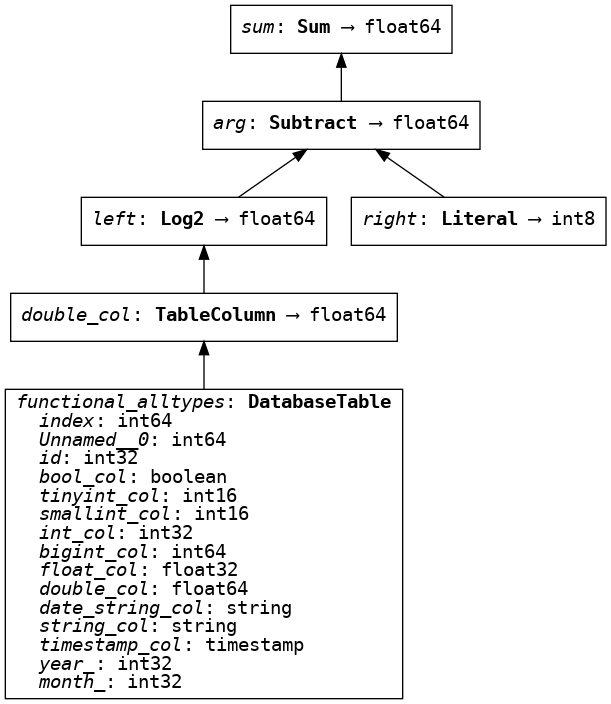

In [17]:
expr2

También podemos ejecutar una expresión llamando a execute en el objeto de conexión Impala

In [18]:
con.execute(col.sum())


331785.00000000006

Hay un atajo para hacer esto un poco más conveniente en uso interactivo


### Interactive mode

Muchas expresiones de Ibis se pueden ejecutar inmediatamente en la base de datos, y puede mejorar su productividad tenerlas ejecutadas para usted cada vez que intente imprimir la expresión en la consola / cuaderno de IPython.

Para hacer esto, tenemos un modo interactivo disponible, que se puede activar / desactivar de esta manera:

In [19]:
ibis.options.interactive = True

Ahora, cualquier expresión que escriba se ejecutará de inmediato

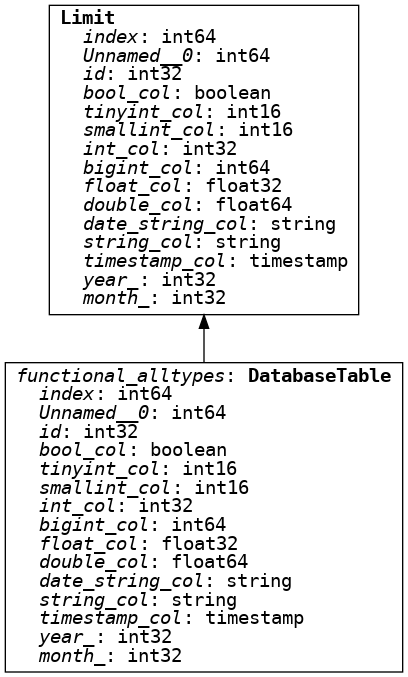

In [20]:
table.limit(10)

Puede seleccionar un rango de fila con sintaxis de corte:

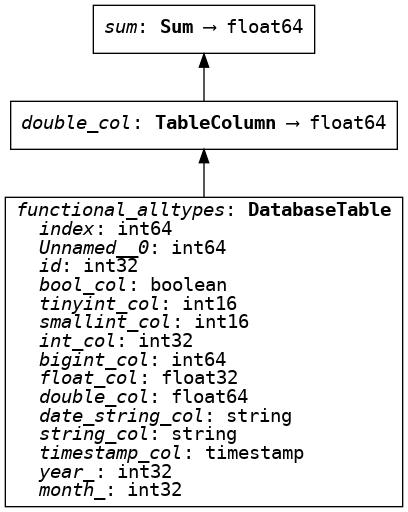

In [21]:
table.double_col.sum()

No se preocupe por la sintaxis aquí, pero las expresiones que resultan en una salida tabular volverán como un DataFrame pandas de forma predeterminada:

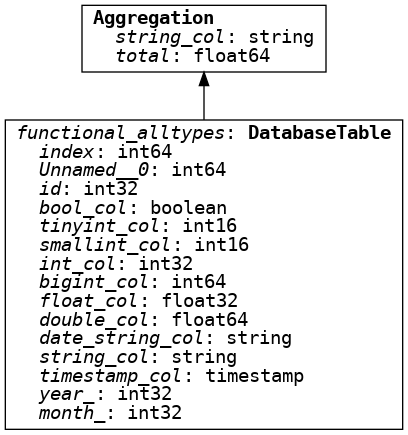

In [22]:
metrics = [table.double_col.sum().name('total')]
expr = table.group_by('string_col').aggregate(metrics)
expr

### Modo detallado y registro

Es posible que desee ver o registrar todas las consultas de OmniSciDB que Ibis ejecuta bajo el capó. Para hacer eso, use la opción options.verbose:

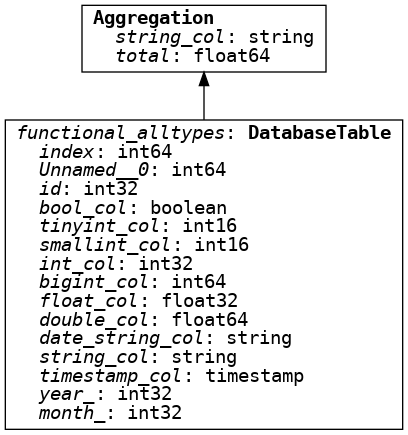

In [23]:

ibis.options.verbose = True

metrics = [table.double_col.sum().name('total')]
expr = table.group_by('string_col').aggregate(metrics)
expr

In [24]:
queries = []
def logger(x):
    queries.append(x)

ibis.options.verbose_log = logger

expr.execute()
expr.execute()

queries

[]

In [25]:
ibis.options.verbose_log = print
ibis.options.verbose = False

### Conceptos básicos de agregación

Una de las funciones esenciales de la API de la tabla es el agregado. La agregación implica lo siguiente

- Una o más expresiones agregadas con nombre, o reducciones
- Cero o más expresiones de agrupación o nombres de columna

Esto termina funcionando de manera muy similar al mecanismo `groupby` de pandas.

Comencemos con una simple reducción:

In [26]:
metric = table.double_col.sum()

Como viste anteriormente, puedes ejecutar esto inmediatamente y obtener un valor:

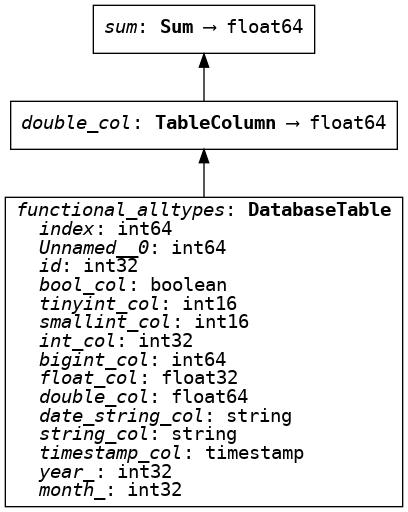

In [27]:
metric

La columna reducida puede ser más compleja; por ejemplo, podría contar el número de valores nulos en una columna de la siguiente manera:

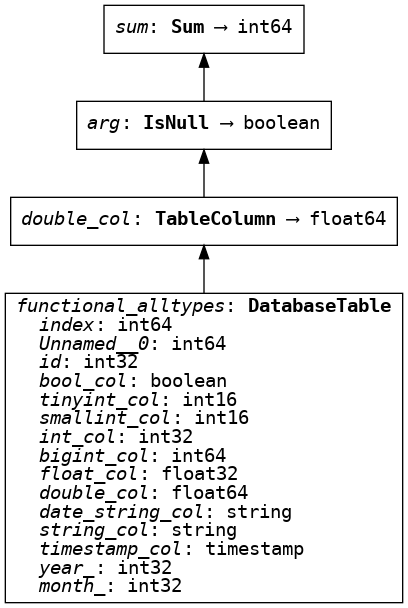

In [28]:
table.double_col.isnull().sum()

Para agregar una tabla, potencialmente con claves de agrupación, tenemos que dar un nombre a la reducción y llamadar `aggregate`

In [29]:
metric = metric.name('double_total')
expr = table.aggregate([metric])
result = con.execute(expr)
result

,double_total
0,331785.0


El resultado aquí es en realidad un DataFrame de pandas con 1 fila y solo una columna. Podemos agregar otra métrica y agregar una clave de agrupación

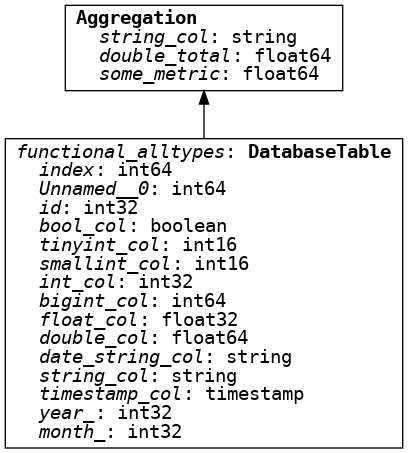

In [30]:
metric2 = (table.bigint_col + 1).log10().max().name('some_metric')

expr = table.aggregate([metric, metric2], by=['string_col'])
expr

Proporcionamos un grupo de conveniencia, a la panda, para que esto sea un poco más composible:

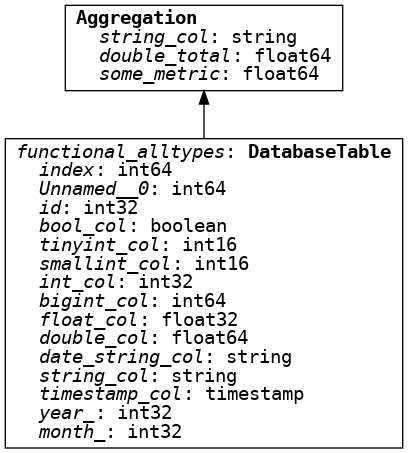

In [31]:
expr = (table.group_by('string_col')
        .aggregate([metric, metric2]))
expr

## Operaciones Geo Espaciales

Ibis suporta operaciones geo espaciales, actualmente disponible para los backend `omniscidb/mapd` y `postgres/postgis`.

También están presentes alguns `literals` geo espaciales:

* POINT
* LINESTRING
* POLYGON
* MULTIPOLYGON

Normalmente, cuando un backend retorna algún dato, lo presenta en `pandas` `Dataframe`. En los backends `omniscidb` y `postgis`, cuando una expresión resulta datos geo espaciales, la salida será un objeto `geopandas` `GeoDataFrame` y eso nos permite generar gráficos facilmente y aplicar operaciones geo espaciales más finas.

In [32]:
import matplotlib.pyplot as plt

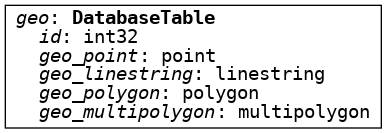

In [33]:
t_geo = con.table('geo')
t_geo

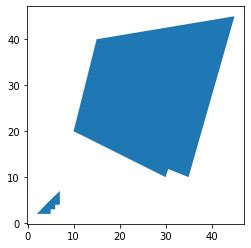

In [34]:
t_geo.geo_polygon.execute().plot()
plt.show()

In [35]:
point = ibis.literal((0, 0), type='point').name('tmp')
point.compile()

"SELECT ST_GeomFromText('POINT (0 0)') AS tmp"

In [36]:
polygon = ibis.literal(
    (
        ((1, 0), (0, 1), (-1, 0), (0, -1), (1, 0)),
        ((0.1, 0), (0, 0.1), (-0.1, 0), (0, -0.1), (0.1, 0)),
    ),
    type='polygon;4326:geometry',
).name('p')

polygon.compile()

"SELECT ST_GeomFromText('POLYGON ((1 0, 0 1, -1 0, 0 -1, 1 0), (0.1 0, 0 0.1, -0.1 0, 0 -0.1, 0.1 0))', 4326) AS tmp"

### Continua ... 

## Ejercícios

Explora las siguientes operaciones:

- sin
- cos
- tan
- sum
- mean
- operaciones matemáticas como +, -, /, *


## ¿Cómo contribuir?

¿Quíeres conbribuir al proyecto Ibis-framework? 

Algunos pasos que puedes dar para empezar a ayudar al proyecto:

- Revise la página https://docs.ibis-project.org/contributing.html
- Si te gusta Ibis-framework, da un click en `star` en su página en GitHub
- Revise las issues `good first issue` https://github.com/ibis-project/ibis/labels/good%20first%20issue
- Únete a al canal de Ibis en Gitter: https://gitter.im/ibis-dev/Lobby


## Referencias

**Ibis-framework**

- https://github.com/ibis-project/ibis
- https://docs.ibis-project.org/
- https://youtu.be/GwlK7JjH7NQ
- https://docs.ibis-project.org/tutorial.html
- http://labs.quansight.org/blog/2019/07/ibis-python-data-analysis-productivity-framework/


**OmniSciDB**

- https://github.com/omnisci/omniscidb